In [ ]:
%tensorflow_version 2.x

In [ ]:
from os import listdir
from google.colab.patches import cv2_imshow
import h5py
import numpy as np
import cv2 as cv
import tensorflow as tf
import math
from matplotlib import pyplot as plt
from google.colab import drive
import pickle
import pandas as pd
import base64
from random import randint
print("Imported")

Imported


In [ ]:
# access google drive
drive.mount('/content/drive')

Mounted at /content/drive


Settings

In [ ]:
# subimages
input_size = 33
label_size = 21
stride = 14
edge = int((input_size - label_size) / 2)

# dataset split
split = 900

# file paths
ae_outputs = "/content/drive/MyDrive/dataset/ae_output.hdf5"
dataset = "/content/drive/MyDrive/dataset/dataset.hdf5"
training_data = "/content/drive/MyDrive/dataset/srcnn_train.h5"
weights_data = f"/content/drive/MyDrive/checkpoints/srcnn_weights.ckpt"
training_results_path = f"/content/drive/MyDrive/srcnn_results.pickle"

# processes
run_train = False
run_test = True
run_graphs = True

Color Conversions

In [ ]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

print("defined")

defined


Prepare Training Data

In [ ]:
# generate training subimages and save them to HDF5 file
def prepare_training_data():
  # image settings

  input = []
  label = []
  
  ae_file = h5py.File(ae_outputs, 'r')
  ds_file = h5py.File(dataset, 'r')

  for i in range(0, split):
    image_input = np.array(ae_file['output'][i]) * 255
    image_label = np.array(ds_file['celeba'][i])

    # change color space to ycrcb
    image_input = rgb2ycbcr(image_input)
    image_label = rgb2ycbcr(image_label)

    # only use luminance and normalize
    image_input = image_input[:, :, 0].astype(np.float) / 255.0
    image_label = image_label[:, :, 0].astype(np.float) / 255.0

    # generate input and label subimages
    h = image_input.shape[0]
    w = image_input.shape[1]
    for r in range(0, h - input_size, stride):
      for c in range(0, w - input_size, stride):
        # use the stride to generate subimage
        subimage_input = image_input[r : r + input_size, c : c + input_size]
        subimage_label = image_label[r + edge : r + edge + label_size, c + edge : c + edge + label_size]

        # reshape to add third dimension for training
        subimage_input = subimage_input.reshape(input_size, input_size, 1)
        subimage_label = subimage_label.reshape(label_size, label_size, 1)

        # add to lists
        input.append(subimage_input)
        label.append(subimage_label)


  # shuffle the subimage data
  count = len(input)
  order = np.random.choice(count, count, replace=False)
  input = np.array([input[i] for i in order])
  label = np.array([label[i] for i in order])

  print(f"Prepared Training Data: {len(input)}")

  # save the training data to an HDF5 file
  with h5py.File(training_data, 'w') as td:
    td.create_dataset('input', data=input)
    td.create_dataset('label', data=label)

  ae_file.close()
  ds_file.close()

  print("saved")

print("defined")

defined


In [ ]:
prepare_training_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Prepared Training Data: 21600
saved


Build SRCNN

In [ ]:
def build_srcnn(learning_rate):
  # filter counts
  n1, n2, n3 = 64, 32, 1
  # filter sizes
  f1, f2, f3 = 9, 5, 5

  srcnn = tf.keras.models.Sequential()
  # Patch Extraction: 64 9x9 filters, no padding, ReLU
  srcnn.add(tf.keras.layers.Conv2D(n1, (f1, f1), padding="VALID", activation='relu', input_shape=(104, 88, 1)))
  # Non-linear Mapping: 32 5x5 filters, padding, ReLU
  srcnn.add(tf.keras.layers.Conv2D(n2, (f2, f2), padding="SAME", activation='relu'))
  # Reconstruction: 1 5x5 filter, no padding
  srcnn.add(tf.keras.layers.Conv2D(n3, (f3, f3), padding="VALID", activation='relu'))

  # PSNR custom metric function
  def psnr(y_true, y_pred):
    error = tf.keras.backend.square(y_pred - y_true)
    mse = np.mean(error.numpy()) 
    return 10 * math.log10(1.0 / mse)

  # Gradient Descent to minimize MSE with PSNR as metric
  srcnn.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[psnr],
      run_eagerly=True)

  return srcnn

print("defined")

defined


SRCNN Architecture

In [ ]:
def srcnn_architecture():
  build_srcnn(learning_rate=0).summary()

print("defined")

defined


Train SRCNN

In [ ]:
def train_model():
  # hyperparameters
  learning_rate = 0.0001
  epochs = 150
  batch_size = 128

  # load the training data
  input = []
  label = []
  with h5py.File(training_data, 'r') as td:
    input = np.array(td.get('input'))
    label = np.array(td.get('label'))

  # callback to save weights every epoch
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_data, save_weights_only=True, verbose=1)

  # train model
  srcnn = build_srcnn(learning_rate=learning_rate)
  history = srcnn.fit(x=input, y=label, epochs=epochs, validation_split=0.25, batch_size=batch_size, callbacks=[cp_callback])

  with open(training_results_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print("defined")

defined


Run Training

In [ ]:
if run_train:
  # print model architecture
  srcnn_architecture()

  # create training data
  prepare_training_data()

  # train and save weights
  train_model()

  print("Finished Training")

Preparing Test Data

In [ ]:
# prepare the images for testing
def prepare_test_images():
  images = []
  input_luminances = []
  labels = []

  ae_file = h5py.File(ae_outputs, 'r')
  ds_file = h5py.File(dataset, 'r')

  for i in range(split, 1000):
    image_input = np.array(ae_file['output'][i] * 255)
    image_label = np.array(ds_file['celeba'])

    # change color space to ycrcb
    image_input = rgb2ycbcr(image_input)
    images.append(image_input)

    # isolate luminance
    luminance = image_input[:, :, 0].astype(np.float) / 255.0
    
    # reshape for model input
    luminance = luminance.reshape(luminance.shape[0], luminance.shape[1], 1)

    input_luminances.append(luminance)
    labels.append(image_label)

  ae_file.close()
  ds_file.close()

  return labels, images, input_luminances

print("defined")

defined


Test SRCNN

In [ ]:
def test_model():
  # get test data
  labels, images, input_luminances = prepare_test_images()

  # create model
  model = build_srcnn(0)

  # load trained weights
  model.load_weights(weights_data)

  # define psnr
  def psnr(im1, im2):
    error = np.square(im1 - im2)
    mse = np.mean(error) 
    return 10 * math.log10(255.0**2 / mse)

  # shave borders for same dimensions
  def shave(image, border):
    return image[border:-border, border:-border]

  def pad(image, amount):
    padded = np.zeros((image.shape[0] + amount * 2, image.shape[1] + amount * 2, 3), dtype=image.dtype)
    for r in range(0, image.shape[0]):
      for c in range(0, image.shape[1]):
        padded[r + amount, c + amount, :] = image[r, c, :]
    
    return padded

  outputs = []
  for i in range(0, len(images)):
    label = shave(images[i][:, :, 0], edge)
    
    x = input_luminances[i]
    x = x.reshape(1, x.shape[0], x.shape[1], 1)
    output = model.predict(x)[0, :, :, 0] * 255
    output_image = np.zeros((output.shape[0], output.shape[1], 3))
    output_image[:, :, 0] = output
    output_image[:, :, 1:3] = shave(images[i][:, :, 1:3], edge)
    output_image = ycbcr2rgb(output_image)
    output_image = pad(output_image, 6)

    outputs.append(output_image)

  return outputs

print("defined")

defined


Run Tests

In [ ]:
outputs = test_model()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


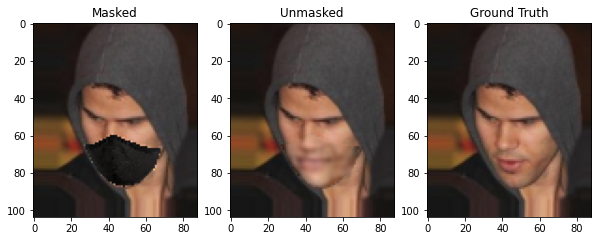

In [ ]:
ae_file = h5py.File(ae_outputs, 'r')
ds_file = h5py.File(dataset, 'r')

figure = plt.figure(figsize=(10, 10))
rand_index = 15

segmap = np.array(ds_file['segmentation_masks'][split + rand_index])
inverse_segmap = (segmap - 1) / 255
masked = np.array(ds_file['masked_faces'][split + rand_index])
removed = (masked / 255) * (np.repeat(np.expand_dims(inverse_segmap, axis=-1), 3, axis=-1))
ae_output = np.array(ae_file['output'][split + rand_index])
srcnn_output = outputs[rand_index] / 255.0
ae_section = ae_output * (np.repeat(np.expand_dims(segmap, axis=-1), 3, axis=-1))
srcnn_section = srcnn_output * (np.repeat(np.expand_dims(segmap, axis=-1), 3, axis=-1))
ae_merged = removed + ae_section
srcnn_merged = removed + srcnn_section
ground_truth = np.array(ds_file['celeba'][split + rand_index])

input_img = figure.add_subplot(231)
plt.imshow(masked)

output_img = figure.add_subplot(232)
plt.imshow(srcnn_merged)

label_img = figure.add_subplot(233)
plt.imshow(ground_truth)

input_img.title.set_text('Masked')
output_img.title.set_text('Unmasked')
label_img.title.set_text('Ground Truth')

ae_file.close()
ds_file.close()

Visualize Training

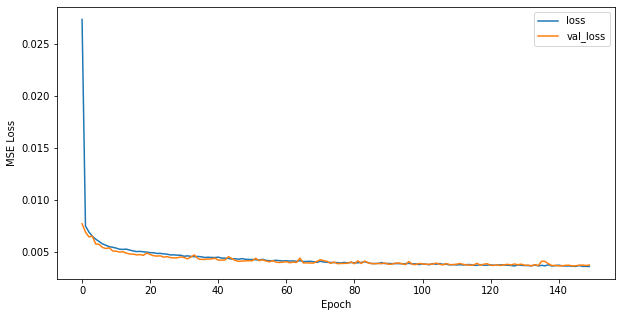

In [ ]:
if run_graphs:
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("MSE Loss")

  history = pickle.load(open(training_results_path, "rb"))
  history = pd.DataFrame(history)

  epochs = list(range(0, 150))

  loss = history['loss']
  val_loss = history['val_loss']
  psnr = history['psnr']
  plt.plot(epochs, loss, label='loss')
  plt.plot(epochs, val_loss, label='val_loss')

  plt.legend()

In [ ]:
srcnn_architecture()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 80, 64)        5248      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 80, 32)        51232     
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 76, 1)         801       
                                                                 
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = build_srcnn(0)
model.load_weights(weights_data)
#model.save('/content/drive/My Drive/models/superresolution/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/superresolution/assets
